# <span style="color:green">Data Understanding</span>
* This data set is off of the SXSW Event twitter feed in 2013 [here](https://schedule.sxsw.com/2013/events/grid?day=8)
* The link to the download of the data set is [here](https://data.world/crowdflower/brands-and-product-emotions)
* The dataset contains 9,093 entries.

# <span style="color:gold">Apple Products in this dataset</span>
* apple                              
* ipad                               
* iPad 
* iphone                             
* Apple 
* iPad or iPhone App
* iPhone 
* Other Apple product or service 
# <span style="color:gold">Google Products mentioned in this data set</span>               
* Google                             
* android                            
* google                              
* Other Google product or service    
* Android App                        
* Android                           
# <span style="color:gold">Product wasn't marked</span>
* Unknown   

# <span style="color:gold">Imports libraries for cleaning</span>

[Here](https://www.nltk.org/) is the documentation for the NLTK import

In [30]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import unicodedata

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/danayt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/danayt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/danayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
df = pd.read_csv('./raw_data/judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')

In [32]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


Looking at the first 5 rows in this dataset using .head() we can see that we are trying to detect the emotion directed at the brand and/or product. 
    
    
<span style="color:gold">Next step lets make these columns cleaner for everyone's sake</span>

In [33]:
df.columns = ["Tweet","Brand/Product","Sentiment"]
df.head()

,Tweet,Brand/Product,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


<span style="color:gold">New Column Explanation</span>
* Tweet - containing tweet text
* Brand/Product -containing the brand or product mentioned in the tweet
* Emotion - containing the indicats of the emotion associated with the tweet

In [34]:
df.isna().sum()

Tweet               1
Brand/Product    5802
Sentiment           0
dtype: int64

In [35]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

allowing us to view DataFrames without any restrictions on the width of columns and without limiting the number of rows displayed. 

# <span style="color:gold">Dealing with the Null's</span>

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Brand/Product  3291 non-null   object
 2   Sentiment      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [37]:
keywords = ['google', 'apple', 'ipad', 'android', 'iphone']

for index, row in df.iterrows():
    text = row['Tweet']
    if pd.isna(row['Brand/Product']) and isinstance(text, str):
        for keyword in keywords:
            if keyword in text.lower():
                df.at[index, 'Brand/Product'] = keyword
                break

In [38]:
df['Brand/Product'].isna().sum()

762

Now we are trying to identify mentions of specific brand or product keywords 
<span style="color:red">(e.g., 'google', 'apple', 'ipad', 'android', 'iphone')</span> 
within the tweet text and populates the <span style="color:red">"Brand/Product"</span> column with the first matching keyword found.

In [39]:
df['Brand/Product'] = df['Brand/Product'].fillna('Unknown')

<span style="color:red">Missing values (NaN)</span> will now have <span style="color:red">'Unknown'</span> as the value instead. This will ensure that the dataset has consistent and meaningful values in place of missing data.

In [40]:
df.isnull().sum()

Tweet            1
Brand/Product    0
Sentiment        0
dtype: int64

In [41]:
df [df['Tweet'].isna()]

,Tweet,Brand/Product,Sentiment
6,NaN,Unknown,No emotion toward brand or product


<span style="color:red">Look's like we can drop this row since it gives us no info</span>

In [42]:
df.dropna(subset=['Tweet'], inplace=True)

In [43]:
df.isnull().sum()

Tweet            0
Brand/Product    0
Sentiment        0
dtype: int64

Great! All values accounted for

In [44]:
df['Brand/Product'].value_counts(normalize = True)

Brand/Product
google                             0.191377
apple                              0.131434
ipad                               0.117576
iPad                               0.104048
Unknown                            0.083700
iphone                             0.078091
Apple                              0.072701
iPad or iPhone App                 0.051694
Google                             0.047294
android                            0.035856
iPhone                             0.032666
Other Google product or service    0.032226
Android App                        0.008909
Android                            0.008579
Other Apple product or service     0.003850
Name: proportion, dtype: float64

Looking at this we see there are a good few categories that we can combine into 3 groups to make them easier to work with later on in our analysis 

* <span style="color:gold">Apple: iPad, Apple, iPad or iPhone App, iphone, Other Apple product or service</span>
* <span style="color:gold">Google: Google, Other Google product or service, Android App, Android</span> 



In [45]:
#mapping products to brands
brand_dict={'iPad': 'Apple', 'iPad or iPhone App': 'Apple', 'iPhone': 'Apple', 
            'Other Google product or service': 'Google', 'Unknown': 'Unknown',
            'Android': 'Google', 'Android App': 'Google',
            'Other Apple product or service': 'Apple',
           'Apple':'Apple',
           'Google': 'Google',
           'apple':'Apple',
           'google': 'Google',
           'ipad':'Apple',
           'android':'Google',
           'iphone':'Apple'}
df['Brand'] = df['Brand/Product'].map(brand_dict)
df['Brand'].unique()

array(['Apple', 'Google', 'Unknown'], dtype=object)

In [46]:
df['Brand'].value_counts(normalize = True)

Brand
Apple      0.592059
Google     0.324241
Unknown    0.083700
Name: proportion, dtype: float64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Brand/Product  9092 non-null   object
 2   Sentiment      9092 non-null   object
 3   Brand          9092 non-null   object
dtypes: object(4)
memory usage: 355.2+ KB


Looking over all of this we can see that we have a cleaned and balanced dataset now

# <span style="color:gold">Let's make brands binary for ease of use</span>

In [48]:
brand_dummies = pd.get_dummies(df['Brand'])
df = pd.concat([df, brand_dummies], axis=1)
df.drop(columns=['Brand'], inplace=True)

In [49]:
df.head()

,Tweet,Brand/Product,Sentiment,Apple,Google,Unknown
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,True,False,False
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,True,False,False
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,True,False,False
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,True,False,False
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,False,True,False


In [51]:
df["Sentiment"] = df["Sentiment"].replace({
    "No emotion toward brand or product": "No emotion",
    "I can't tell": "No emotion"
})

In [52]:
updated_unique_emotions = df["Sentiment"].unique()
updated_unique_emotions

array(['Negative emotion', 'Positive emotion', 'No emotion'], dtype=object)

# <span style="color:gold">Cleaning the Tweet Column</span>

Goals
* Convert all text to lowercase.
* Remove URLs, mentions, and hashtags.
* Remove punctuation and numbers.

In [68]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm", "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [69]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 1]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

 "Tweet" column has now been tokenized, and the results are stored in the "Tokenized_Tweet"

In [56]:
print(df.columns)

Index(['Tweet', 'Brand/Product', 'Sentiment', 'Apple', 'Google', 'Unknown',
       'Tokenized_Tweet'],
      dtype='object')


In [70]:
# Display the dataframe with the new "Tokenized_Tweet" column
df.head()

,Tweet,Brand/Product,Sentiment,Apple,Google,Unknown,Tokenized_Tweet,Tokens_without_stopwords
0,i have a g iphone after hrs tweeting at rise_austin it was dead i need to upgrade plugin stations at sxsw,iPhone,Negative emotion,True,False,False,"[i, have, a, g, iphone, after, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]","[g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]"
1,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at sxsw,iPad or iPhone App,Positive emotion,True,False,False,"[know, about, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]","[know, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts, sxsw]"
2,can not wait for ipad also they should sale them down at sxsw,iPad,Positive emotion,True,False,False,"[can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]","[wait, ipad, also, sale, sxsw]"
3,i hope this years festival isnt as crashy as this years iphone app sxsw,iPad or iPhone App,Negative emotion,True,False,False,"[i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]","[hope, years, festival, isnt, crashy, years, iphone, app, sxsw]"
4,great stuff on fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Google,Positive emotion,False,True,False,"[great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]","[great, stuff, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]"


In [77]:
corpse = df.Tweet
target = df.Sentiment
product = df['Brand/Product']

In [78]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [79]:
token_text

['hr tweet rise austin dead need upgrade plugin station',
 'know awesome ipadiphone app youll likely appreciate design also theyre give free t',
 'wait also sale',
 'hope year festival isnt crashy year app',
 'great stuff fri marissa mayer tim oreilly tech booksconferences amp matt mullenweg wordpress',
 'new apps speechtherapy communication showcased conference iear edchat asd',
 'start ctia around corner googleio hop skip jump good time fan',
 'beautifully smart simple idea rt write hollergram app',
 'counting day plus strong canadian dollar mean stock gear',
 'excited meet show sprint galaxy still run fail',
 'find amp start impromptu party cant wait til app come',
 'foursquare ups game time still prefer far best look app date',
 'gotta love calendar feature top party show case check rt gt',
 'great app',
 'haha awesomely rad app hollergram',
 'holler gram itunes app store',
 'noticed dst come weekend many user hour late come sunday morning',
 'added flight match people planesairpor

<span style="color:gold">Removes common English stopwords (e.g., "the," "and," "in") from a list of tokens</span>

In [82]:
# # Convert the 'product' column to strings
# df['product'] = df['product'].astype(str)

# # Concatenate the "corpse" and "product" columns
# df['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# Assign the concatenated text to X
X = token_text

# Assign the target labels to y
y = df['Sentiment']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [84]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

In [85]:
cv = CountVectorizer()

X_t_cv = cv.fit_transform(X_t)

X_val_cv = cv.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_cv, y_t)
y_hat = mnb.predict(X_val_cv)

precision_score(y_val, y_hat, average='weighted')

0.6251734054745407

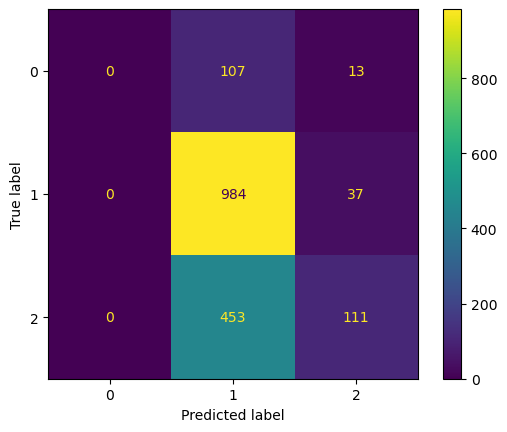

In [87]:
cm = confusion_matrix(y_val, y_hat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# TO DO add the tfdif

In [ ]:
# df.to_csv('cleaned_twitter_data.csv', index=False)

In [86]:
tfidf = TfidfVectorizer()

X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

0.6096972666673777